In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(42)

### Read in the datasets

In [16]:
# Edinburgh
from data_processing import read_edinburgh_data 
# set sampling rate as 9 so that the velocities in the df are correct
edinburgh_data, edinburgh_agent_ids = read_edinburgh_data()

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2342/2342 [01:02<00:00, 37.64it/s]


Warning! too big dt in [Edinburgh]
finish


In [17]:
# ETH - eth
from data_processing import read_eth_data
eth_data, eth_agent_ids = read_eth_data()

In [18]:
# UCY
from data_processing import read_UCY_data
ucy_data, ucy_agent_ids = read_UCY_data()

In [19]:
# HERMES
from data_processing import read_HERMES_data
hermes_data, hermes_agent_ids = read_HERMES_data()

### Neural network setup

In [50]:
from keras import models
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

NN_5_point_model = models.load_model('models/Edinburgh_NN_5_point_pred_velocity', custom_objects={"RMSE": RMSE})
NN_single_point_model = models.load_model('models/Edinburgh_NN_single_point_pred_velocity', custom_objects={"RMSE": RMSE})

In [51]:
edinburgh_test_agent_ids = np.load('Edinburgh_test_agent_ids.npy')

In [66]:
def NN_5p_prediction(model, data, agent_id):
    seen_x = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_x'])
    seen_y = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_y'])
    
    seen_vel_x = np.array(data[data['agent_id'] == agent_id].iloc[1:5]['vel_x'])
    seen_vel_y = np.array(data[data['agent_id'] == agent_id].iloc[1:5]['vel_y'])
    
    unseen_x = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_x'])
    unseen_y = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_y'])

    pred_vel_x, pred_vel_y = model.predict(np.array([np.column_stack((seen_vel_x, seen_vel_y))]))
    pred_vel_x = pred_vel_x[0] # destructure the prediction array as it is [[x1, x2, x3...]]
    pred_vel_y = pred_vel_y[0]
    
    pred_coord_x = [seen_x[-1] + pred_vel_x[0]]
    pred_coord_y = [seen_y[-1] + pred_vel_y[0]]
    
    for i in range(1, 5):
        pred_coord_x.append(pred_coord_x[-1] + pred_vel_x[i])
        pred_coord_y.append(pred_coord_y[-1] + pred_vel_y[i])

    FDE = np.sqrt((pred_coord_x[-1] - unseen_x[-1])**2 + (pred_coord_y[-1] - unseen_y[-1])**2)
    return pred_coord_x, pred_coord_y, FDE

def NN_single_p_prediction(model, data, agent_id):
    seen_x = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_x'])
    seen_y = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_y'])
    
    seen_vel_x = np.array(data[data['agent_id'] == agent_id].iloc[1:5]['vel_x'])
    seen_vel_y = np.array(data[data['agent_id'] == agent_id].iloc[1:5]['vel_y'])
    
    unseen_x = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_x'])
    unseen_y = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_y'])

    rolling_vel_x = np.array(seen_vel_x)
    rolling_vel_y = np.array(seen_vel_y)
    for i in range(5):
        seen_velocities = np.column_stack((rolling_vel_x, rolling_vel_y))
        pred_vel_x, pred_vel_y = model.predict(np.array([seen_velocities]))

        # To get the fifth velocity we need for prediction
        if i == 4:
            rolling_vel_x = np.append(rolling_vel_x, [pred_vel_x[0]])
            rolling_vel_y = np.append(rolling_vel_y, [pred_vel_y[0]])
        else:
            rolling_vel_x = np.append(rolling_vel_x[1:], [pred_vel_x[0]])
            rolling_vel_y = np.append(rolling_vel_y[1:], [pred_vel_y[0]])

    # Create coordinates from the velocity predictions
    pred_coord_x = [seen_x[-1] + rolling_vel_x[0]]
    pred_coord_y = [seen_y[-1] + rolling_vel_y[0]]
    for i in range(1, 5):
        pred_coord_x.append(pred_coord_x[i-1] + rolling_vel_x[i])
        pred_coord_y.append(pred_coord_y[i-1] + rolling_vel_y[i])
        
    # Calculate final displacement error
    FDE = np.sqrt((pred_coord_x[-1] - unseen_x[-1])**2 + (pred_coord_y[-1] - unseen_y[-1])**2)
    return pred_coord_x, pred_coord_y, FDE

### Baseline models

In [67]:
def generate_data(data, begin_idx, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y

In [68]:
def avg_vel_const(data, agent_id):
    sample_x, sample_y, test_x, test_y = generate_data(data, 0, agent_id, 5)
    
    sample_vel_x = [sample_x[i] - sample_x[i-1] for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] for i in range(1, len(sample_y))]
    
    avg_vel_x = np.mean(sample_vel_x)
    avg_vel_y = np.mean(sample_vel_y)
    
    pred_x = [sample_x[-1] + i*avg_vel_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*avg_vel_y for i in range(1, 6)]
    
    FDE = np.sqrt((pred_x[-1] - test_x[-1])**2 + (pred_y[-1] - test_y[-1])**2)
    return FDE, pred_x, pred_y

def last_vel_const(data, agent_id):
    sample_x, sample_y, test_x, test_y = generate_data(data, 0, agent_id, 5)
    
    sample_vel_x = [sample_x[i] - sample_x[i-1] for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] for i in range(1, len(sample_y))]
    
    last_vel_x = sample_vel_x[-1]
    last_vel_y = sample_vel_y[-1]
    
    pred_x = [sample_x[-1] + i*last_vel_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*last_vel_y for i in range(1, 6)]
    
    FDE = np.sqrt((pred_x[-1] - test_x[-1])**2 + (pred_y[-1] - test_y[-1])**2)
    return FDE, pred_x, pred_y

def discount_vel_const(data, agent_id):
    sample_x, sample_y, test_x, test_y = generate_data(data, 0, agent_id, 5)
    
    sample_vel_x = [sample_x[i] - sample_x[i-1] for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] for i in range(1, len(sample_y))]
    
    disc_avg_x = (0.8**3*sample_vel_x[0] + 0.8**2*sample_vel_x[1] + 0.8*sample_vel_x[2] + sample_vel_x[3]) / (0.8**3 + 0.8**2 + 0.8 + 1)
    disc_avg_y = (0.8**3*sample_vel_y[0] + 0.8**2*sample_vel_y[1] + 0.8*sample_vel_y[2] + sample_vel_y[3]) / (0.8**3 + 0.8**2 + 0.8 + 1)
    
    pred_x = [sample_x[-1] + i*disc_avg_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*disc_avg_y for i in range(1, 6)]
    
    FDE = np.sqrt((pred_x[-1] - test_x[-1])**2 + (pred_y[-1] - test_y[-1])**2)
    return FDE, pred_x, pred_y

def avg_acc_const(data, agent_id):
    sample_x, sample_y, test_x, test_y = generate_data(data, 0, agent_id, 5)
    
    sample_vel_x = [sample_x[i] - sample_x[i-1] for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] for i in range(1, len(sample_y))]
    
    sample_acceleration_x = [sample_vel_x[i] - sample_vel_x[i-1] for i in range(1, len(sample_vel_x))]
    sample_acceleration_y = [sample_vel_y[i] - sample_vel_y[i-1] for i in range(1, len(sample_vel_y))]
    
    avg_acceleration_x = np.mean(sample_acceleration_x)
    avg_acceleration_y = np.mean(sample_acceleration_y)

    last_vel_x = sample_vel_x[-1]
    last_vel_y = sample_vel_y[-1]
    
    pred_x = [sample_x[-1] + last_vel_x + avg_acceleration_x]
    pred_y = [sample_y[-1] + last_vel_y + avg_acceleration_y]
    for i in range(1, 5):
        pred_x.append(pred_x[i-1] + last_vel_x + i * avg_acceleration_x)
        pred_y.append(pred_y[i-1] + last_vel_y + i * avg_acceleration_y)
        
    FDE = np.sqrt((pred_x[-1] - test_x[-1])**2 + (pred_y[-1] - test_y[-1])**2)
    return FDE, pred_x, pred_y
        
def last_acc_const(data, agent_id):
    sample_x, sample_y, test_x, test_y = generate_data(data, 0, agent_id, 5)
    
    sample_vel_x = [sample_x[i] - sample_x[i-1] for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] for i in range(1, len(sample_y))]
    
    avg_vel_x = np.mean(sample_vel_x)
    avg_vel_y = np.mean(sample_vel_y)
    
    sample_acceleration_x = [sample_vel_x[i] - sample_vel_x[i-1] for i in range(1, len(sample_vel_x))]
    sample_acceleration_y = [sample_vel_y[i] - sample_vel_y[i-1] for i in range(1, len(sample_vel_y))]
    
    last_acceleration_x = sample_acceleration_x[-1]
    last_acceleration_y = sample_acceleration_y[-1]
    
    last_vel_x = sample_vel_x[-1]
    last_vel_y = sample_vel_y[-1]
    
    pred_x = [sample_x[-1] + last_vel_x + last_acceleration_x]
    pred_y = [sample_y[-1] + last_vel_y + last_acceleration_y]
    for i in range(1, 5):
        pred_x.append(pred_x[i-1] + last_vel_x + i * last_acceleration_x)
        pred_y.append(pred_y[i-1] + last_vel_y + i * last_acceleration_y)
        
    FDE = np.sqrt((pred_x[-1] - test_x[-1])**2 + (pred_y[-1] - test_y[-1])**2)
    return FDE, pred_x, pred_y

def discount_acc_const(data, agent_id):
    sample_x, sample_y, test_x, test_y = generate_data(data, 0, agent_id, 5)
    
    sample_vel_x = [sample_x[i] - sample_x[i-1] for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] for i in range(1, len(sample_y))]
    
    avg_speed_x = np.mean(sample_vel_x)
    avg_speed_y = np.mean(sample_vel_y)
    
    sample_acc_x = [sample_vel_x[i] - sample_vel_x[i-1] for i in range(1, len(sample_vel_x))]
    sample_acc_y = [sample_vel_y[i] - sample_vel_y[i-1] for i in range(1, len(sample_vel_y))]
    
    discounted_avg_acc_x = (0.8**2*sample_acc_x[0] + 0.8*sample_acc_x[1] + sample_acc_x[2]) / (0.8**2 + 0.8 + 1)
    discounted_avg_acc_y = (0.8**2*sample_acc_y[0] + 0.8*sample_acc_y[1] + sample_acc_y[2]) / (0.8**2 + 0.8 + 1)

    last_vel_x = sample_vel_x[-1]
    last_vel_y = sample_vel_y[-1]
    
    pred_x = [sample_x[-1] + last_vel_x + discounted_avg_acc_x]
    pred_y = [sample_y[-1] + last_vel_y + discounted_avg_acc_y]
    
    for i in range(1, 5):
        pred_x.append(pred_x[i-1] + last_vel_x + i * discounted_avg_acc_x)
        pred_y.append(pred_y[i-1] + last_vel_y + i * discounted_avg_acc_y)


    FDE = np.sqrt((pred_x[-1] - test_x[-1])**2 + (pred_y[-1] - test_y[-1])**2)
    return FDE, pred_x, pred_y

### Evaluation

In [69]:
def run_models(data, test_agent_ids):
    NN_5p_FDE = []
    NN_single_p_FDE = []
    avg_vel_const_FDE = []
    last_vel_const_FDE = []
    discount_vel_const_FDE = []
    avg_acc_const_FDE = []
    last_acc_const_FDE = []
    discount_acc_const_FDE = []
    
    NN_5p_preds = {}
    NN_single_p_preds = {}
    avg_vel_const_preds = {}
    last_vel_const_preds = {}
    discount_vel_const_preds = {}
    avg_acc_const_preds = {}
    last_acc_const_preds = {}
    discount_acc_const_preds = {}

    for idx, agent_id in enumerate(test_agent_ids):
        NN_5p = NN_5p_prediction(NN_5_point_model, data, agent_id)
        NN_5p_FDE.append(NN_5p[2])
        NN_5p_preds[agent_id] = (NN_5p[0], NN_5p[1])
        
        NN_single_p = NN_single_p_prediction(NN_single_point_model, data, agent_id)
        NN_single_p_FDE.append(NN_single_p[2])
        NN_single_p_preds[agent_id] = (NN_single_p[0], NN_single_p[1])
                        
        avg_vel_const_data = avg_vel_const(data, agent_id)
        avg_vel_const_FDE.append(avg_vel_const_data[0])
        avg_vel_const_preds[agent_id] = (avg_vel_const_data[1], avg_vel_const_data[2])
        
        last_vel_const_data = last_vel_const(data, agent_id)
        last_vel_const_FDE.append(last_vel_const_data[0])
        last_vel_const_preds[agent_id] = (last_vel_const_data[1], last_vel_const_data[2])
        
        discount_vel_const_data = discount_vel_const(data, agent_id)
        discount_vel_const_FDE.append(discount_vel_const_data[0])
        discount_vel_const_preds[agent_id] = (discount_vel_const_data[1], discount_vel_const_data[2])
        
        avg_acc_const_data = avg_acc_const(data, agent_id)
        avg_acc_const_FDE.append(avg_acc_const_data[0])
        avg_acc_const_preds[agent_id] = (avg_acc_const_data[1], avg_acc_const_data[2])
        
        last_acc_const_data = last_acc_const(data, agent_id)
        last_acc_const_FDE.append(last_acc_const_data[0])
        last_acc_const_preds[agent_id] = (last_acc_const_data[1], last_acc_const_data[2])
        
        discount_acc_const_data = discount_acc_const(data, agent_id)
        discount_acc_const_FDE.append(discount_acc_const_data[0])
        discount_acc_const_preds[agent_id] = (discount_acc_const_data[1], discount_acc_const_data[2])
    
    res_FDE = [
        np.mean(NN_5p_FDE),
        np.mean(NN_single_p_FDE),
        np.mean(avg_vel_const_FDE),
        np.mean(last_vel_const_FDE),
        np.mean(discount_vel_const_FDE),
        np.mean(avg_acc_const_FDE),
        np.mean(last_acc_const_FDE),
        np.mean(discount_acc_const_FDE)
    ]
    
    res_preds = {
        'NN_5_p': NN_5p_preds,
        'NN_single_p': NN_single_p_preds,
        'avg_vel': avg_vel_const_preds,
        #'last_vel': last_vel_const_preds,
        #'discount_vel': discount_vel_const_preds,
        'avg_acc': avg_acc_const_preds,
        #'last_acc': last_acc_const_preds,
        #'discount_acc': discount_acc_const_preds
    }
    
    return res_FDE, res_preds

In [70]:
edinburgh_FDE, edinburgh_preds = run_models(edinburgh_data, edinburgh_test_agent_ids)
eth_FDE, eth_preds = run_models(eth_data, eth_agent_ids)
ucy_FDE, ucy_preds = run_models(ucy_data, ucy_agent_ids)
hermes_FDE, hermes_preds = run_models(hermes_data, hermes_agent_ids)

In [71]:
index = [
    'Neural network 5p prediction',
    'Neural network single point rolling prediction',
    'Average velocity as const',
    'Last velocity as const',
    'Discounted velocity as const',
    'Average acceleration as const',
    'Last acceleration as const',
    'Discounted acceleration as const'
]

df_data = {
    'Edinburgh' : pd.Series(edinburgh_FDE, index = index),
    'ETH' : pd.Series(eth_FDE, index = index),
    'UCY' : pd.Series(ucy_FDE, index = index),
    'HERMES': pd.Series(hermes_FDE, index = index)
}

df = pd.DataFrame(df_data)

### Results

In [72]:
df

,Edinburgh,ETH,UCY,HERMES
Neural network 5p prediction,1.043201,1.549525,0.663673,0.784845
Neural network single point rolling prediction,1.323535,1.992670,0.943276,0.994651
Average velocity as const,1.427050,0.816345,0.429664,0.319157
Last velocity as const,1.398270,0.675217,0.326290,0.366872
Discounted velocity as const,1.344767,0.733045,0.402204,0.313469
Average acceleration as const,2.540697,1.179001,0.551277,0.544653
Last acceleration as const,4.511113,2.245425,0.687313,1.087280
Discounted acceleration as const,2.557960,1.175476,0.572964,0.580070


### Plots

673


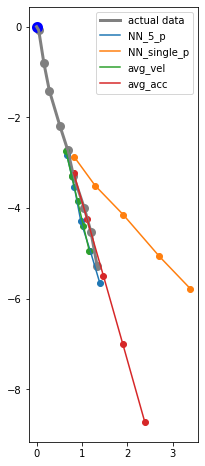

953


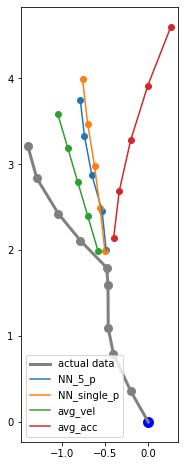

1144


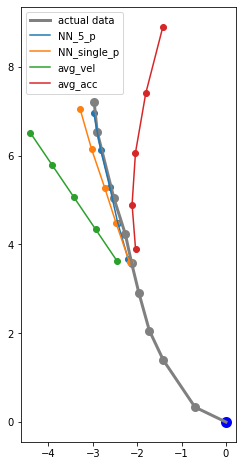

963


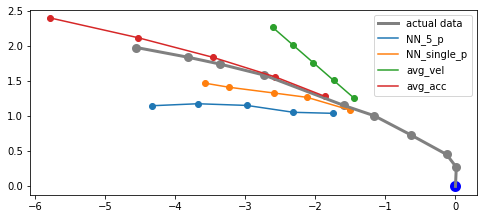

545


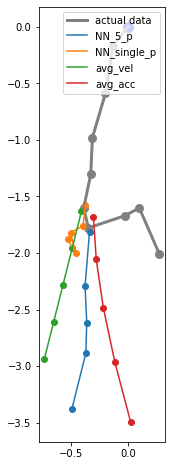

117


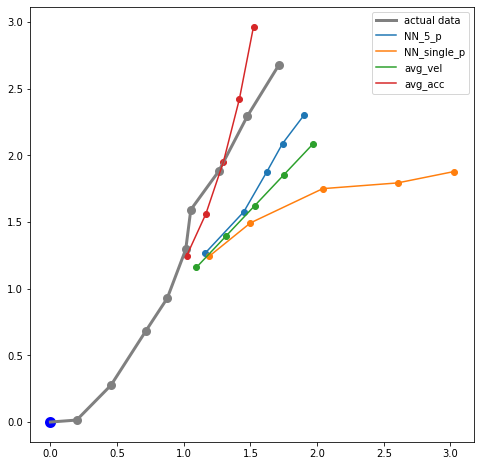

1067


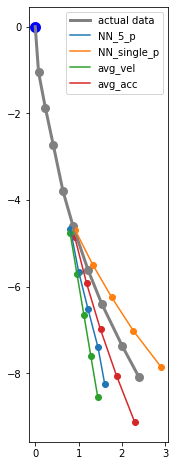

439


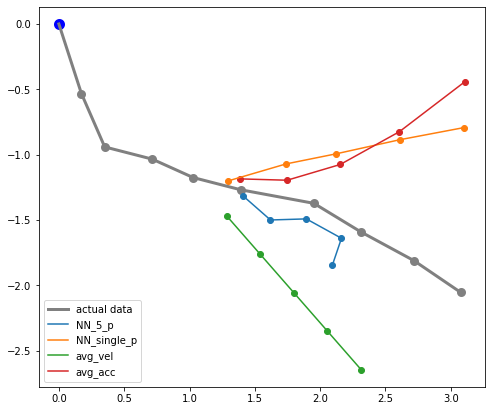

1703


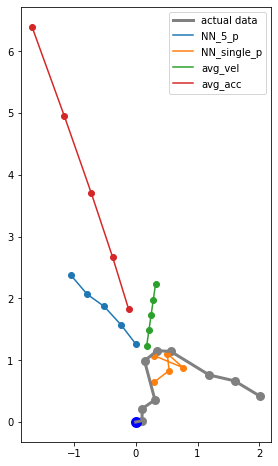

In [73]:
for agent_id in edinburgh_test_agent_ids[11:20]:
    print(agent_id)
    
    sample_x, sample_y, test_x, test_y = generate_data(edinburgh_data, 0, agent_id, 5)
    # Plot actual data
    plt.figure(figsize=(8, 8))
    plt.axes().set_aspect('equal')
    
    plt.plot(np.append(sample_x, test_x), np.append(sample_y, test_y), label="actual data", color='gray', linewidth=3)
    plt.scatter(np.append(sample_x, test_x), np.append(sample_y, test_y), color='gray', linewidth=3)
    plt.scatter(sample_x[0], sample_y[0], color='b', linewidth=5)
    plt.scatter(sample_x[-1], sample_y[-1], color='gray')
        
    for key in edinburgh_preds:
        pred_x = edinburgh_preds[key][agent_id][0]
        pred_y = edinburgh_preds[key][agent_id][1]
        
        plt.plot(pred_x, pred_y, label=key)
        plt.scatter(pred_x, pred_y)

    plt.legend()
    plt.show()